## POS tagging using modified Viterbi

An HMM-based POS tagger and Viterbi algorithm have been implemented using the Penn Treebank training corpus. The vanilla Viterbi algorithm written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

In this assignment, the Viterbi algorithm has been modified to solve the problem of unknown words using two techniques:

- Approach 1: Considering either of transition or emission probabilities if one is 0
- Approach 2 Fallback to rule-based tagging

The file given [here](https://cdn.upgrad.com/UpGrad/temp/9dca5f3b-53c3-47e1-86d5-5ec5dafad6f0/Test_sentences.txt) has been used for testing.

For this assignment, the Treebank dataset of NLTK with the 'universal' tagset has been used. The [Universal tagset of NLTK](https://www.nltk.org/_modules/nltk/tag/mapping.html) comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

### Data Preparation

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from urllib.request import urlopen

In [2]:
# Set ipython's max row display
pd.set_option('display.max_row', 150)

In [3]:
# download/update universal_tagset. skipped if updated version already available
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/saman.tamkeen/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

#### Utility methods

**1. Print utility**

In [4]:
# utility method for pretty printing tagged sentences
def print_sentences(sentences):
    for sentence in sentences:
        print(sentence, '\n')

**2. Accuracy for unknown words**

In [5]:
# defined as percent of unknown words correctly tagged
def accuracy_on_unknown_words(method):
    correctly_identified = len(unknown_tagged_words_merged_df[unknown_tagged_words_merged_df['manual'] == unknown_tagged_words_merged_df[method]])
    total_unknown = len(unknown_tagged_words_merged_df)
    return correctly_identified/total_unknown

#### Read and explore treebank corpus

In [6]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
len(nltk_data)

3914

In [7]:
# first few tagged sentences
print_sentences(nltk_data[:5])

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')] 

[('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')] 

[('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), (

#### Read and explore test data

In [8]:
# reading the test file
file = urlopen("https://cdn.upgrad.com/UpGrad/temp/9dca5f3b-53c3-47e1-86d5-5ec5dafad6f0/Test_sentences.txt")
test_sentences = [word_tokenize(sentence.decode("utf-8")) for sentence in file if sentence.decode("utf-8") != '\r\n']
print_sentences(test_sentences)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.'] 

['Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.'] 

['Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.'] 

['Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.'] 

['Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.'] 

['The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.'] 

['This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern'

#### Test train split

In [9]:
# Splitting into train and test
train_set, test_set = train_test_split(nltk_data, test_size=0.05)
print(len(train_set))
print(len(test_set))

3718
196


In [10]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95728

In [11]:
test_tagged_words_with_tags = [tup for sent in test_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
len(test_tagged_words)

4948

In [12]:
# number of tags
tags = set([pair[1] for pair in train_tagged_words])
print(len(tags))
print(tags)

12
{'ADP', 'DET', 'PRON', 'ADJ', 'NOUN', '.', 'NUM', 'PRT', 'X', 'VERB', 'ADV', 'CONJ'}


### Build the vanilla Viterbi based POS tagger

#### Emission Probability

In [13]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transition probability

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

#### Unknown words

In [15]:
# count of words vs tags from test file
test_words = set([tup for sent in test_sentences for tup in sent])
word_tag_count = [(word, tag, word_given_tag(word, tag)[0]) for word in test_words for tag in tags]
word_tag_count_df = pd.DataFrame.from_records(word_tag_count, columns=['word','tag','count'])
word_tag_count_df = word_tag_count_df.pivot(index='word', columns='tag', values=['count']).reset_index()
word_tag_count_df.columns = [col[1] if col[0] != 'word' else col[0] for col in word_tag_count_df.columns.values]
word_tag_count_df

,word,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
0,'s,0,0,0,0,0,0,0,0,0,726,94,0
1,",",4652,0,0,0,0,0,0,0,0,0,0,0
2,.,3635,0,0,0,0,0,0,0,0,0,0,0
3,11th,0,1,0,0,0,0,0,0,0,0,0,0
4,2011,0,0,0,0,0,0,0,0,0,0,0,0
5,2013,0,0,0,0,0,0,0,0,0,0,0,0
6,2015,0,0,0,0,0,0,0,0,0,0,0,0
7,2018,0,0,0,0,0,0,0,0,0,0,0,0
8,21st,0,0,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,17,0,0,0,3


In [16]:
columns = word_tag_count_df.columns.tolist()
columns.remove('word')
unknown_words = word_tag_count_df.loc[(word_tag_count_df[columns]==0).all(axis=1)].word.tolist()
print('# of unknown words: ', len(unknown_words))
print(unknown_words)

# of unknown words:  28
['2011', '2013', '2015', '2018', '21st', 'Android', 'Cup', 'FIFA', 'Google', 'ICESAT-2', 'NASA', 'OS', 'Satellite', 'Twitter', 'arriving', 'contested', 'domineering', 'firehose', 'interact', 'invited', 'messages', 'online', 'personality', 'smartphones', 'tournament', 'trips', 'tweets', 'worldwide']


#### Transition probability matrix

In [17]:
# transistion probability of tags as a dataframe
tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,ADP,DET,PRON,ADJ,NOUN,.,NUM,PRT,X,VERB,ADV,CONJ
ADP,0.017097,0.322608,0.068706,0.105979,0.323564,0.038866,0.064139,0.001380,0.034406,0.008708,0.013699,0.000850
DET,0.009053,0.005552,0.003621,0.204224,0.639831,0.018105,0.021726,0.000121,0.045383,0.039348,0.012674,0.000362
PRON,0.022325,0.009238,0.006543,0.074673,0.209777,0.041570,0.006928,0.012702,0.091994,0.485758,0.033872,0.004619
ADJ,0.078635,0.004451,0.000659,0.065941,0.699472,0.063633,0.021266,0.011045,0.020936,0.012364,0.004451,0.017145
NOUN,0.177476,0.013132,0.004874,0.012222,0.263905,0.240115,0.009640,0.043833,0.028846,0.145902,0.017169,0.042887
.,0.090868,0.173925,0.065547,0.044806,0.223310,0.093472,0.080183,0.002424,0.027117,0.088264,0.052707,0.057287
NUM,0.035599,0.003236,0.001471,0.034128,0.355987,0.118270,0.183878,0.027067,0.205060,0.018829,0.003236,0.013239
PRT,0.021625,0.100590,0.017693,0.086173,0.247051,0.041284,0.058650,0.001966,0.013761,0.399083,0.010157,0.001966
X,0.145277,0.053860,0.056097,0.017101,0.063769,0.162698,0.002877,0.184274,0.072559,0.205370,0.025891,0.010229
VERB,0.092061,0.134982,0.035456,0.064303,0.109089,0.034990,0.023249,0.031180,0.218957,0.168883,0.081331,0.005521


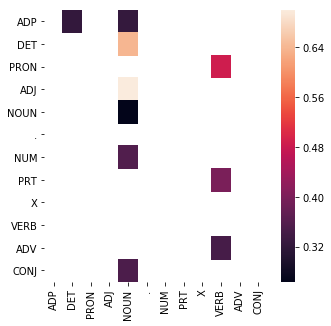

In [18]:
# frequent tags
# filter the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(5, 5))
sns.heatmap(tags_frequent)
plt.show()

#### Viterbi implementation

In [19]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            word_given_tag_tuple = word_given_tag(words[key], tag)
            emission_p = word_given_tag_tuple[0]/word_given_tag_tuple[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluation on validation set

In [20]:
tagged_seq = Viterbi(test_tagged_words)
print(tagged_seq)

[('It', 'PRON'), ('also', 'ADV'), ('would', 'VERB'), ('junk', 'NOUN'), ('an', 'DET'), ('innovative', 'ADP'), ('market-based', 'ADP'), ('system', 'NOUN'), ('for', 'ADP'), ('*', 'X'), ('trading', 'NOUN'), ('emissions', 'NOUN'), ('credits', 'NOUN'), ('among', 'ADP'), ('polluters', 'ADP'), ('.', '.'), ('The', 'DET'), ('purchases', 'NOUN'), ('show', 'NOUN'), ('the', 'DET'), ('strong', 'ADJ'), ('interest', 'NOUN'), ('of', 'ADP'), ('Japanese', 'ADJ'), ('investors', 'NOUN'), ('in', 'ADP'), ('U.S.', 'NOUN'), ('mortgage-based', 'ADP'), ('instruments', 'NOUN'), (',', '.'), ('Fannie', 'NOUN'), ('Mae', 'NOUN'), ("'s", 'PRT'), ('chairman', 'NOUN'), (',', '.'), ('David', 'NOUN'), ('O.', 'ADP'), ('Maxwell', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('at', 'ADP'), ('a', 'DET'), ('news', 'NOUN'), ('conference', 'NOUN'), ('.', '.'), ('A', 'DET'), ('steady', 'ADJ'), ('deposit', 'NOUN'), ('base', 'NOUN'), ('.', '.'), ('Chemical', 'NOUN'), ('Bank', 'NOUN'), ('spent', 'VERB'), ('more

In [21]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_tagged_words_with_tags) if i == j]
accuracy_vanilla = len(check)/len(tagged_seq)
accuracy_vanilla

0.9040016168148747

#### Evaluate on test sentences

In [22]:
tagged_test_sentences = [Viterbi(test_sentence) for test_sentence in test_sentences]
print_sentences(tagged_test_sentences)

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')] 

[('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.')] 

[('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose', 'ADP'), ('.', '.')] 

[('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('use

In [23]:
tagged_test_words = [tup for sent in tagged_test_sentences for tup in sent]
unknown_tagged_words = [word for word in tagged_test_words if word[0] in unknown_words]
unknown_tagged_words

[('Android', 'ADP'),
 ('Google', 'ADP'),
 ('Android', 'ADP'),
 ('OS', 'ADP'),
 ('worldwide', 'ADP'),
 ('smartphones', 'ADP'),
 ('2011', 'ADP'),
 ('2013', 'ADP'),
 ('Google', 'ADP'),
 ('Twitter', 'ADP'),
 ('2015', 'ADP'),
 ('Google', 'ADP'),
 ('Twitter', 'ADP'),
 ('firehose', 'ADP'),
 ('Twitter', 'ADP'),
 ('online', 'ADP'),
 ('interact', 'ADP'),
 ('messages', 'ADP'),
 ('tweets', 'ADP'),
 ('domineering', 'ADP'),
 ('personality', 'ADP'),
 ('2018', 'ADP'),
 ('FIFA', 'ADP'),
 ('Cup', 'ADP'),
 ('21st', 'ADP'),
 ('FIFA', 'ADP'),
 ('Cup', 'ADP'),
 ('tournament', 'ADP'),
 ('contested', 'ADP'),
 ('Cup', 'ADP'),
 ('trips', 'ADP'),
 ('arriving', 'ADP'),
 ('NASA', 'ADP'),
 ('invited', 'ADP'),
 ('ICESAT-2', 'ADP'),
 ('Satellite', 'ADP')]

All unknown words are marked as **ADP** (first tag) by default

### Solve the problem of unknown words

#### Approach 1: Considering either of transition or emission probabilities if one is 0

In [24]:
# Viterbi Heuristic
def Viterbi_V2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        t = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            word_given_tag_tuple = word_given_tag(words[key], tag)
            emission_p = word_given_tag_tuple[0]/word_given_tag_tuple[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
            t.append(transition_p)

        if all(v == 0 for v in p):
            tmax = max(t)
            state_max = T[t.index(tmax)]
        else:
            pmax = max(p)
            state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

#### Evaluate on validation set

In [25]:
tagged_seq_v2 = Viterbi_V2(test_tagged_words)
print(tagged_seq_v2)

[('It', 'PRON'), ('also', 'ADV'), ('would', 'VERB'), ('junk', 'NOUN'), ('an', 'DET'), ('innovative', 'NOUN'), ('market-based', 'NOUN'), ('system', 'NOUN'), ('for', 'ADP'), ('*', 'X'), ('trading', 'NOUN'), ('emissions', 'NOUN'), ('credits', 'NOUN'), ('among', 'ADP'), ('polluters', 'NOUN'), ('.', '.'), ('The', 'DET'), ('purchases', 'NOUN'), ('show', 'NOUN'), ('the', 'DET'), ('strong', 'ADJ'), ('interest', 'NOUN'), ('of', 'ADP'), ('Japanese', 'ADJ'), ('investors', 'NOUN'), ('in', 'ADP'), ('U.S.', 'NOUN'), ('mortgage-based', 'NOUN'), ('instruments', 'NOUN'), (',', '.'), ('Fannie', 'NOUN'), ('Mae', 'NOUN'), ("'s", 'PRT'), ('chairman', 'NOUN'), (',', '.'), ('David', 'NOUN'), ('O.', 'NOUN'), ('Maxwell', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('at', 'ADP'), ('a', 'DET'), ('news', 'NOUN'), ('conference', 'NOUN'), ('.', '.'), ('A', 'DET'), ('steady', 'ADJ'), ('deposit', 'NOUN'), ('base', 'NOUN'), ('.', '.'), ('Chemical', 'NOUN'), ('Bank', 'NOUN'), ('spent', 'VERB'), (

In [26]:
# accuracy
check = [i for i, j in zip(tagged_seq_v2, test_tagged_words_with_tags) if i == j]
accuracy_v2 = len(check)/len(tagged_seq_v2)
accuracy_v2

0.9361358124494745

#### Evaluate on test sentences

In [27]:
tagged_test_sentences_V2 = [Viterbi_V2(test_sentence) for test_sentence in test_sentences]
print_sentences(tagged_test_sentences_V2)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')] 

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')] 

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')] 

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 

In [28]:
tagged_test_words_V2 = [tup for sent in tagged_test_sentences_V2 for tup in sent]
unknown_tagged_words_V2 = [word for word in tagged_test_words_V2 if word[0] in unknown_words]
unknown_tagged_words_V2

[('Android', 'NOUN'),
 ('Google', 'NOUN'),
 ('Android', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('smartphones', 'NOUN'),
 ('2011', 'NOUN'),
 ('2013', 'NOUN'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('2015', 'NOUN'),
 ('Google', 'X'),
 ('Twitter', 'VERB'),
 ('firehose', 'VERB'),
 ('Twitter', 'NOUN'),
 ('online', 'NOUN'),
 ('interact', 'NOUN'),
 ('messages', 'NOUN'),
 ('tweets', 'NOUN'),
 ('domineering', 'NOUN'),
 ('personality', 'NOUN'),
 ('2018', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'NOUN'),
 ('Cup', 'NOUN'),
 ('trips', 'NOUN'),
 ('arriving', 'NOUN'),
 ('NASA', 'NOUN'),
 ('invited', 'NOUN'),
 ('ICESAT-2', 'NOUN'),
 ('Satellite', 'NOUN')]

#### Approach 2: Fallback to rule-based tagging

In [29]:
# define rule-based tagger with following regex rules
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),              # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
]
regexp_tagger = nltk.RegexpTagger(patterns)

In [30]:
# Viterbi Heuristic
def Viterbi_V3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        regex_tag = 'NOUN'
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            word_given_tag_tuple = word_given_tag(words[key], tag)
            emission_p = word_given_tag_tuple[0]/word_given_tag_tuple[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
            regex_tag = regexp_tagger.tag([words[key]])[0][1]
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] if pmax > 0 else regex_tag
        state.append(state_max)
    return list(zip(words, state))

#### Evaluate on validation set

In [31]:
tagged_seq_v3 = Viterbi_V3(test_tagged_words)
print(tagged_seq_v3)

[('It', 'PRON'), ('also', 'ADV'), ('would', 'VERB'), ('junk', 'NOUN'), ('an', 'DET'), ('innovative', 'NOUN'), ('market-based', 'VERB'), ('system', 'NOUN'), ('for', 'ADP'), ('*', 'X'), ('trading', 'NOUN'), ('emissions', 'NOUN'), ('credits', 'NOUN'), ('among', 'ADP'), ('polluters', 'NOUN'), ('.', '.'), ('The', 'DET'), ('purchases', 'NOUN'), ('show', 'NOUN'), ('the', 'DET'), ('strong', 'ADJ'), ('interest', 'NOUN'), ('of', 'ADP'), ('Japanese', 'ADJ'), ('investors', 'NOUN'), ('in', 'ADP'), ('U.S.', 'NOUN'), ('mortgage-based', 'VERB'), ('instruments', 'NOUN'), (',', '.'), ('Fannie', 'NOUN'), ('Mae', 'NOUN'), ("'s", 'PRT'), ('chairman', 'NOUN'), (',', '.'), ('David', 'NOUN'), ('O.', 'NOUN'), ('Maxwell', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('at', 'ADP'), ('a', 'DET'), ('news', 'NOUN'), ('conference', 'NOUN'), ('.', '.'), ('A', 'DET'), ('steady', 'ADJ'), ('deposit', 'NOUN'), ('base', 'NOUN'), ('.', '.'), ('Chemical', 'NOUN'), ('Bank', 'NOUN'), ('spent', 'VERB'), (

In [32]:
# accuracy
check = [i for i, j in zip(tagged_seq_v3, test_tagged_words_with_tags) if i == j]
accuracy_v3 = len(check)/len(tagged_seq_v3)
accuracy_v3

0.944624090541633

#### Evaluate on test sentences

In [33]:
tagged_test_sentences_V3 = [Viterbi_V3(test_sentence) for test_sentence in test_sentences]
print_sentences(tagged_test_sentences_V3)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')] 

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')] 

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')] 

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 

In [34]:
tagged_test_words_V3 = [tup for sent in tagged_test_sentences_V3 for tup in sent]
unknown_tagged_words_V3 = [word for word in tagged_test_words_V3 if word[0] in unknown_words]
unknown_tagged_words_V3

[('Android', 'NOUN'),
 ('Google', 'NOUN'),
 ('Android', 'NOUN'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('smartphones', 'VERB'),
 ('2011', 'NUM'),
 ('2013', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('2015', 'NUM'),
 ('Google', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('firehose', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('online', 'NOUN'),
 ('interact', 'NOUN'),
 ('messages', 'VERB'),
 ('tweets', 'NOUN'),
 ('domineering', 'VERB'),
 ('personality', 'NOUN'),
 ('2018', 'NUM'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('21st', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Cup', 'NOUN'),
 ('tournament', 'NOUN'),
 ('contested', 'VERB'),
 ('Cup', 'NOUN'),
 ('trips', 'NOUN'),
 ('arriving', 'VERB'),
 ('NASA', 'NOUN'),
 ('invited', 'VERB'),
 ('ICESAT-2', 'NOUN'),
 ('Satellite', 'NOUN')]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [35]:
# manual tagging of unknown words
unknown_tagged_words_manual = [
    ('2011', 'NUM'),
    ('2013', 'NUM'),
    ('2015', 'NUM'),
    ('2018', 'NUM'),
    ('21st', 'ADJ'),
    ('Android', 'NOUN'),
    ('Cup', 'NOUN'),
    ('FIFA', 'NOUN'),
    ('Google', 'NOUN'),
    ('ICESAT-2', 'NOUN'),
    ('NASA', 'NOUN'),
    ('OS', 'NOUN'),
    ('Satellite', 'NOUN'),
    ('Twitter', 'NOUN'),
    ('arriving', 'VERB'),
    ('contested', 'VERB'),
    ('domineering', 'ADJ'),
    ('firehose', 'NOUN'),
    ('interact', 'VERB'),
    ('invited', 'VERB'),
    ('messages', 'NOUN'),
    ('online', 'ADJ'),
    ('personality', 'NOUN'),
    ('smartphones', 'NOUN'),
    ('tournament', 'NOUN'),
    ('trips', 'NOUN'),
    ('tweets', 'NOUN'),
    ('worldwide', 'NOUN')
]
print(unknown_tagged_words_manual)

[('2011', 'NUM'), ('2013', 'NUM'), ('2015', 'NUM'), ('2018', 'NUM'), ('21st', 'ADJ'), ('Android', 'NOUN'), ('Cup', 'NOUN'), ('FIFA', 'NOUN'), ('Google', 'NOUN'), ('ICESAT-2', 'NOUN'), ('NASA', 'NOUN'), ('OS', 'NOUN'), ('Satellite', 'NOUN'), ('Twitter', 'NOUN'), ('arriving', 'VERB'), ('contested', 'VERB'), ('domineering', 'ADJ'), ('firehose', 'NOUN'), ('interact', 'VERB'), ('invited', 'VERB'), ('messages', 'NOUN'), ('online', 'ADJ'), ('personality', 'NOUN'), ('smartphones', 'NOUN'), ('tournament', 'NOUN'), ('trips', 'NOUN'), ('tweets', 'NOUN'), ('worldwide', 'NOUN')]


In [36]:
# compare tagging of unknown words for all implementation
unknown_tagged_words_manual_df = pd.DataFrame.from_records(unknown_tagged_words_manual, columns=['word','tag'])
unknown_tagged_words_vanilla_df = pd.DataFrame.from_records(unknown_tagged_words, columns=['word','tag'])
unknown_tagged_words_V2_df = pd.DataFrame.from_records(unknown_tagged_words_V2, columns=['word','tag'])
unknown_tagged_words_V3_df = pd.DataFrame.from_records(unknown_tagged_words_V3, columns=['word','tag'])
unknown_tagged_words_merged_df = unknown_tagged_words_manual_df.merge(unknown_tagged_words_vanilla_df, right_on='word', left_on='word', how='left').rename(columns={'tag_x':'manual','tag_y':'vanilla'})
unknown_tagged_words_merged_df = unknown_tagged_words_merged_df.merge(unknown_tagged_words_V2_df, right_on='word', left_on='word', how='left')
unknown_tagged_words_merged_df = unknown_tagged_words_merged_df.merge(unknown_tagged_words_V3_df, right_on='word', left_on='word', how='left').rename(columns={'tag_x':'v2', 'tag_y':'v3'})
unknown_tagged_words_merged_df.drop_duplicates(inplace=True)
unknown_tagged_words_merged_df

,word,manual,vanilla,v2,v3
0,2011,NUM,ADP,NOUN,NUM
1,2013,NUM,ADP,NOUN,NUM
2,2015,NUM,ADP,NOUN,NUM
3,2018,NUM,ADP,NOUN,NUM
4,21st,ADJ,ADP,NOUN,NOUN
5,Android,NOUN,ADP,NOUN,NOUN
13,Cup,NOUN,ADP,NOUN,NOUN
40,FIFA,NOUN,ADP,NOUN,NOUN
48,Google,NOUN,ADP,NOUN,NOUN
54,Google,NOUN,ADP,X,NOUN


In [37]:
compare_df = pd.DataFrame.from_records([('vanilla', accuracy_vanilla, accuracy_on_unknown_words('vanilla')),
                                        ('v2', accuracy_v2, accuracy_on_unknown_words('v2')),
                                        ('v3', accuracy_v3, accuracy_on_unknown_words('v3'))], 
                                       columns=['implementation', 'accuracy_overall', 'accuracy_on_unknown_words'])
compare_df

,implementation,accuracy_overall,accuracy_on_unknown_words
0,vanilla,0.904002,0.000000
1,v2,0.936136,0.533333
2,v3,0.944624,0.800000


- The overall accuracy of modified viterbi implementations are better than the vanilla implementation, rule-based fallback for unknown words being slightly better than transition probability based implementation.
- The modified implementations are significantly better at tagging unknown words than vanilla implementation

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [38]:
print('List of words correctly tagged by modified transition probability based implementation')
unknown_tagged_words_merged_df[unknown_tagged_words_merged_df['manual'] == unknown_tagged_words_merged_df['v2']][['word','manual','vanilla','v2']]

List of words correctly tagged by modified transition probability based implementation


,word,manual,vanilla,v2
5,Android,NOUN,ADP,NOUN
13,Cup,NOUN,ADP,NOUN
40,FIFA,NOUN,ADP,NOUN
48,Google,NOUN,ADP,NOUN
75,ICESAT-2,NOUN,ADP,NOUN
76,NASA,NOUN,ADP,NOUN
77,OS,NOUN,ADP,NOUN
78,Satellite,NOUN,ADP,NOUN
79,Twitter,NOUN,ADP,NOUN
112,messages,NOUN,ADP,NOUN


In [39]:
print('List of words correctly tagged by modified rule based implementation')
unknown_tagged_words_merged_df[unknown_tagged_words_merged_df['manual'] == unknown_tagged_words_merged_df['v3']][['word','manual','vanilla','v3']]

List of words correctly tagged by modified rule based implementation


,word,manual,vanilla,v3
0,2011,NUM,ADP,NUM
1,2013,NUM,ADP,NUM
2,2015,NUM,ADP,NUM
3,2018,NUM,ADP,NUM
5,Android,NOUN,ADP,NOUN
13,Cup,NOUN,ADP,NOUN
40,FIFA,NOUN,ADP,NOUN
48,Google,NOUN,ADP,NOUN
54,Google,NOUN,ADP,NOUN
75,ICESAT-2,NOUN,ADP,NOUN
